In [56]:
%load_ext autoreload
%autoreload 2
import pytesseract
from skimage.filters import threshold_local
import argparse
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#import helpers as imutils
%matplotlib inline
import imutils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
image = cv2.imread('vin11.jpg')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

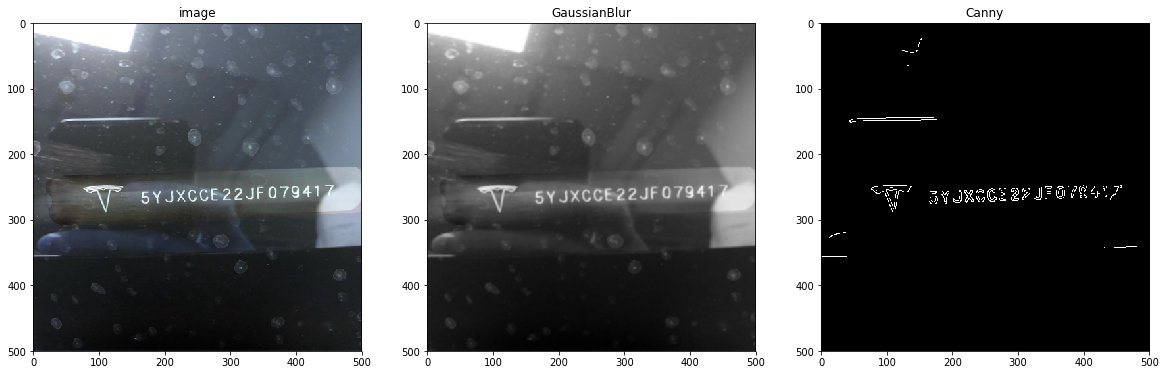

In [58]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 150, 250)

#plt.imshow(edged)

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('image')
ax1.imshow(image, cmap='gray')
ax2.set_title('GaussianBlur')
ax2.imshow(gray, cmap='gray')
ax3.set_title('Canny')
ax3.imshow(edged, cmap='gray')

3.4.1


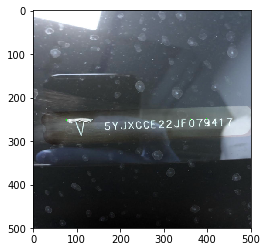

In [59]:

cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(cv2.__version__)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.95 * peri, True)
    cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4: 
        screenCnt = approx
        break
#print(screenCnt)
#cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(image)

In [60]:
#apply perspective transform 
#https://www.pyimagesearch.com/2015/02/02/just-open-sourced-personal-imutils-package-series-opencv-convenience-functions/
#https://github.com/schollz/python-ocr
warped = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 19, offset = 5, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

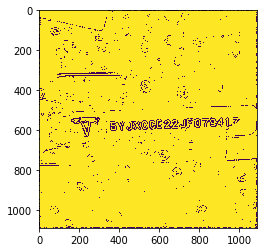

In [61]:
plt.imshow(warped)
text = pytesseract.image_to_string(warped)


In [62]:
print(text)

In [141]:
IMAGE_SIZE = 1800
BINARY_THREHOLD = 180


def image_smoothening(img):
    ret1, th1 = cv2.threshold(img,105, 250, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 130, 250, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (5, 5), 1)
    ret3, th3 = cv2.threshold(th2, 135, 250, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

def remove_noise_and_smooth(img):
    filtered = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 41, 3)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

In [142]:
image1 = cv2.imread('vin11.jpg')
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
length_x, width_y = gray1.shape[:2]
factor = max(1, int(IMAGE_SIZE / length_x))
size = (factor * length_x, factor * width_y)
resized = cv2.resize(gray1, size)
#plt.imshow(resized)

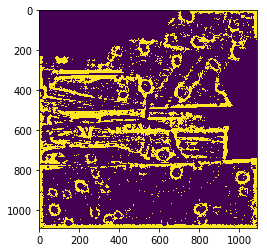

In [143]:
im_new = remove_noise_and_smooth(resized)
retval, binary = cv2.threshold(im_new, 205, 255, cv2.THRESH_BINARY_INV)
plt.imshow(binary)

In [140]:
text = pytesseract.image_to_string(binary)
print(text)